In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import re

In [2]:
GAMMAS = ['1.0','0.9','0.8','0.7','0.6','0.5']
INDEX_TIME_UNIT = 1000 # number of tweets
QUERY_TIME_UNIT = 1000 # number of tweets
SIMILARITY_THRE = 0.5
NUMBER_OF_RUNS = 3
OUTPUT_DIR = "./output_expm1/n11/"

def get_chance(gamma):
    if gamma == '1.0':
        return '100'
    elif gamma == '0.9':
        return '90'
    elif gamma == '0.8':
        return '80'
    elif gamma == '0.7':
        return '70'
    elif gamma == '0.6':
        return '60'
    elif gamma == '0.5':
        return '50'
    
def get_gamma_index(gamma):
    if gamma == '1.0':
        return 0
    elif gamma == '0.9':
        return 1
    elif gamma == '0.8':
        return 2
    elif gamma == '0.7':
        return 3
    elif gamma == '0.6':
        return 4
    elif gamma == '0.5':
        return 5
    
SUMMARY_INDEX = pd.Index(['Run', 'Chance', 'Index time unit', 'Query time unit', 'Similarity threshold', 
                 'Query counts', 'Indexed tweet counts', 'Index size'])
SUMMARY_COL = ['Summary_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_RESULT_COL = ['Result_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_SIMILARITY_COL = ['Similarity_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_LOOKUPS_COL = ['Lookups_' + get_chance(p) + '%' for p in GAMMAS]
INDEX_TIME_COL = ['Index_time_run{}_{}%'.format(str(i+1), get_chance(p)) for p in GAMMAS for i in range(NUMBER_OF_RUNS)]
QUERY_TIME_COL = ['Query_time_run{}_{}%'.format(str(i+1), get_chance(p)) for p in GAMMAS for i in range(NUMBER_OF_RUNS)]

FREQ_TABLES_X = ['Posting_list_length_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_RECALL_X = ['Query_recall_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_PRECISION_X = ['Query_precision_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_LESS_LOOKUPS_X = ['Query_of_less_lookups_' + get_chance(p) + '%' for p in GAMMAS]
AVERAGE_LOOKUPS_X = ['Average_lookup_counts_' + get_chance(p) + '%' for p in GAMMAS]
PLOT_X = [get_chance(p) + '%' for p in GAMMAS]

# Run Experiment  One and Read in Results

* Use single terms to construct index
* Each term has a 100% chance to 50% chance to be included in the index or fingerprint

In [3]:
def runSketchTweets(jar, index_time_unit, query_time_unit, chance_gamma, similarity_threshold, n, output_dir):
    for run in range (1, n+1):
        os.system("java -jar ./{}.jar -iu {} -qu {} -p {} -s {} -n {} -o {}"
        .format(jar, index_time_unit, query_time_unit, chance_gamma, similarity_threshold, run, output_dir))
#         print("java -jar ./{}.jar -iu {} -qu {} -p {} -s {} -n {} -o {}"
#         .format(jar, index_time_unit, query_time_unit, chance_gamma, similarity_threshold, run, output_dir))

In [4]:
# This function runs the experiment and compares the results including:
# - the size of the index and doc lists 
# - time for constructing the index and executing query 
# - number of lookups before finding the match

def run_expm1():
    for p in GAMMAS:
        runSketchTweets("SketchingTweet-v1_n11", INDEX_TIME_UNIT, QUERY_TIME_UNIT, p, SIMILARITY_THRE, NUMBER_OF_RUNS, OUTPUT_DIR)
    results = load_expm1_csv(OUTPUT_DIR)
    return results

In [5]:
def load_expm1_csv(directory):
    '''
    Returns a dictionary of results.
    The dictionary keys are: summary, termfreq, query_results_similarity_lookups, index_time, query_time
    '''
    results = {}
    summary = [0] * len(GAMMAS)
    termfreq = [0] * len(GAMMAS)
    query_result = [0] * len(GAMMAS)
    query_similarity = [0] * len(GAMMAS)
    query_lookups = [0] * len(GAMMAS)
    index_time = [[0 for j in range(NUMBER_OF_RUNS)] for i in range(len(GAMMAS))]
    query_time = [[0 for j in range(NUMBER_OF_RUNS)] for i in range(len(GAMMAS))]
      

    for root, _, files in os.walk(directory):
        for file in files:
            filename = re.match( r'Epoch_(\d+)_iu_(\d+)_qu_(\d+)_p_(\d+\.\d+)_s_([\.\d]+)_(.+).csv', file)  
#             print(filename.group(3),filename.group(4),filename.group(5),filename.group(6))
            name = filename.group(6)
            gamma = filename.group(4)

            if name == "summary":    
                for p in GAMMAS:
                    if gamma == p:
                        summary[get_gamma_index(gamma)] = pd.read_csv(directory + "/" + file, header=None)

            if name == "term_freq":
                for p in GAMMAS:
                    if gamma == p:
                        termfreq[get_gamma_index(gamma)] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "query_result":
                for p in GAMMAS:
                    if gamma == p:
                        query_result[get_gamma_index(gamma)] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "query_similarity":
                for p in GAMMAS:
                    if gamma == p:
                        query_similarity[get_gamma_index(gamma)] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "lookups":
                for p in GAMMAS:
                    if gamma == p:
                        query_lookups[get_gamma_index(gamma)] = pd.read_csv(directory + "/" + file, header=None)
            
            if name == "index_time":
                run = filename.group(1)
                for p in GAMMAS:
                    if gamma == p:
                        for i in range(0,NUMBER_OF_RUNS):
                            if run == str(i+1):
                                index_time[get_gamma_index(gamma)][i] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "query_time":
                run = filename.group(1)
                for p in GAMMAS:
                    if gamma == p:
                        for i in range(0,NUMBER_OF_RUNS):
                            if run == str(i+1):
                                query_time[get_gamma_index(gamma)][i] = pd.read_csv(directory + "/" + file, header=None)
                  
    
    summary = pd.concat(summary, 1)
    summary = summary.set_index(SUMMARY_INDEX)
    summary.columns = SUMMARY_COL
#     print(summary)
    
    for table in termfreq:
        termfreq_index = table.iloc[:,0]
        table.set_index(termfreq_index, inplace=True)
        table.drop(table.columns[0], axis=1, inplace=True)
        table.columns = ['number_of_terms', 'posting_count']
#     print(termfreq)
    
    query_result = pd.concat(query_result, 1)
    query_result.columns = QUERY_RESULT_COL
#     print(query_result)
    
    query_similarity = pd.concat(query_similarity, 1)
    query_similarity.columns = QUERY_SIMILARITY_COL
#     print(query_similarity)

    query_lookups = pd.concat(query_lookups, 1)
    query_lookups.columns = QUERY_LOOKUPS_COL
#     print(query_lookups)

    query_result_similarity_lookup = [query_result, query_similarity, query_lookups]
    query_result_similarity_lookup = pd.concat(query_result_similarity_lookup, 1)
#     print(query_result_similarity_lookup)
    
    index_time_dfs = []
    for p in index_time:
        index_time_df = pd.concat(p, 1)
        index_time_dfs.append(index_time_df)
    index_time = pd.concat(index_time_dfs, 1)
    index_time.columns = INDEX_TIME_COL
    
    query_time_dfs = []
    for p in query_time:
        query_time_df = pd.concat(p, 1)
        query_time_dfs.append(query_time_df)
    query_time = pd.concat(query_time_dfs, 1)
    query_time.columns = QUERY_TIME_COL
    
    results['summary'] = summary
    results['termfreq'] = termfreq
    results['query_result_similarity_lookup'] = query_result_similarity_lookup
    results['index_time'] = index_time
    results['query_time'] = query_time
  
    return results

In [6]:
results = run_expm1() 

# Process Results

In [7]:
def plot_linechart(title, x, y, x_label, y_label, scale='linear'):
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.yscale(scale)
    plt.show()
    
def plot_scatter(title, x, y, x_label, y_label, scale='linear'):
    plt.scatter(x, y, s=0.5)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.yscale(scale)
    plt.show()
    
def plot_barchart(title, x, y, x_label, y_label, color="#66B3BA"):
    layer = sns.barplot(x=x, y=y, color=color)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
    
def plot_boxplot(title, data, y_label, scale='linear'):
    layer = sns.boxplot(data=data)
    layer = sns.stripplot(data=data, color="orange", jitter=0.2, size=1.5)
    plt.title(title)
    plt.ylabel(y_label)
    plt.yscale(scale)
    plt.show()

## Index size comparison

In [8]:
summary = results['summary']
summary

Summary_100% Summary_90% Summary_80% Summary_70%  \
Run                             1           1           1           1   
Chance                     100.0%       90.0%       80.0%       70.0%   
Index time unit              1000        1000        1000        1000   
Query time unit              1000        1000        1000        1000   
Similarity threshold     0.500000    0.500000    0.500000    0.500000   
Query counts                21890       21890       21890       21890   
Indexed tweet counts       197610      197610      197610      197610   
Index size                 215201      201911      192315      182372   

                     Summary_60% Summary_50%  
Run                            1           1  
Chance                     60.0%       50.0%  
Index time unit             1000        1000  
Query time unit             1000        1000  
Similarity threshold    0.500000    0.500000  
Query counts               21890       21890  
Indexed tweet counts      197610      197610  
Index size                172347      162184

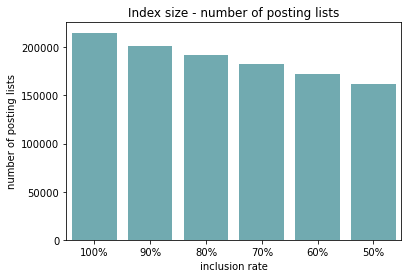

Summary_100%    215201
Summary_90%     201911
Summary_80%     192315
Summary_70%     182372
Summary_60%     172347
Summary_50%     162184
Name: Index size, dtype: object

In [9]:
# index size - number of posting lists
def compare_index_size(sizes, title):
    data = pd.to_numeric(sizes).to_list()
    plot_barchart(title, PLOT_X, data, 'inclusion rate', 'number of posting lists')

compare_index_size(summary.loc['Index size'], "Index size - number of posting lists")
summary.loc['Index size']

## Documnet list length comparison

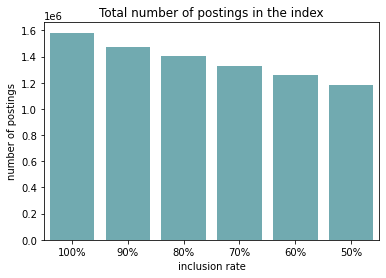

Total number of postings:


[1582263, 1470840, 1405101, 1324409, 1259943, 1184373]

In [10]:
freq_tables = results['termfreq']
posting_list_length_distribution = [table['posting_count'].value_counts().sort_index(inplace=False) for table in freq_tables]
total_posting_counts = [sum(table['posting_count']) for table in freq_tables]
plot_barchart('Total number of postings in the index', PLOT_X, total_posting_counts, 'inclusion rate', 'number of postings')
print('Total number of postings:')
total_posting_counts

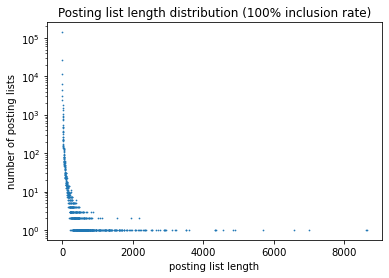

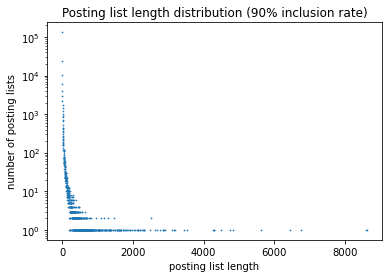

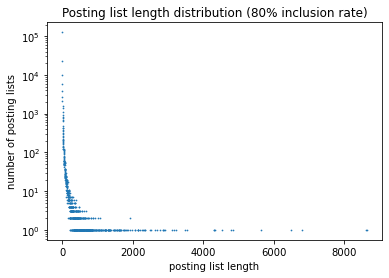

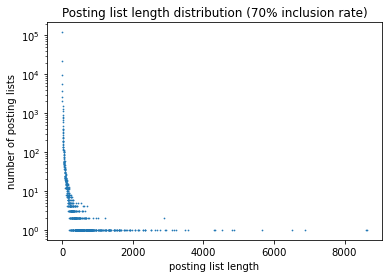

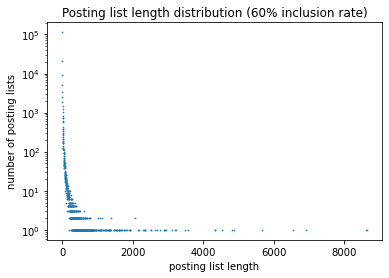

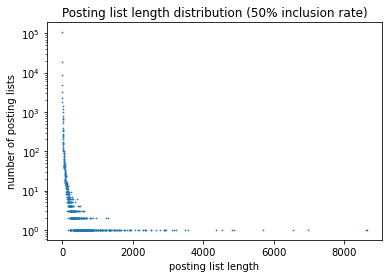

In [11]:
def compare_postinglist_length_distribution(PLOT_X, posting_list_length_distribution):
    for i in range(len(PLOT_X)):
        title = f'Posting list length distribution ({PLOT_X[i]} inclusion rate)'
        x = posting_list_length_distribution[i].index
        y = posting_list_length_distribution[i]
        plot_scatter(title, x, y, 'posting list length', 'number of posting lists', scale='log')   
compare_postinglist_length_distribution(PLOT_X, posting_list_length_distribution)

Average posting list length
[7.352489068359348, 7.284595688199256, 7.306247562592621, 7.262129054898779, 7.310501488276558, 7.302650076456371]


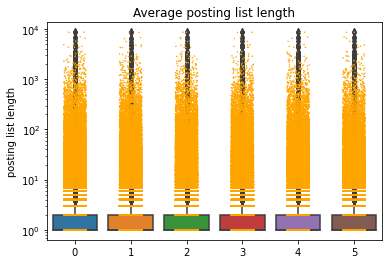

In [12]:
def compare_posting_list_len(PLOT_X, freq_tables):
    lengths = [table['posting_count'] for table in freq_tables]
    avgs = [sum(l)/len(l) for l in lengths]
    print("Average posting list length")
    print(avgs)
#     index15 = [int(round(len(l)*0.15,0)) for l in lengths]
#     index85 = [int(round(len(l)*0.85,0)) for l in lengths]
#     nooutlier_lengths = [ lengths[i][index15[i]:index85[i]] for i in range(len(lengths))]
    plot_boxplot(f'Average posting list length', lengths, 'posting list length', scale='log')
    
compare_posting_list_len(PLOT_X, freq_tables)

## Query Recall

In [13]:
query_result_similarity_lookup = results['query_result_similarity_lookup']
query_result_similarity_lookup

Result_100%  Result_90%  Result_80%  Result_70%  Result_60%  \
0           189567      189567      189567      189567      189567   
1           146028      146028      146028      146028      146028   
2               -1          -1          -1      145908      145908   
3               -1          -1          -1          -1          -1   
4               -1          -1          -1          -1          -1   
...            ...         ...         ...         ...         ...   
21885           -1          -1          -1          -1          -1   
21886           -1          -1          -1          -1          -1   
21887           -1          -1          -1          -1          -1   
21888           -1          -1          -1          -1          -1   
21889       197524      197524      197524      197524      197524   

       Result_50%  Similarity_100%  Similarity_90%  Similarity_80%  \
0          189567          0.63636           0.700           0.700   
1              -1          0.50000           0.600           0.600   
2          145908          0.00000           0.000           0.000   
3              -1          0.00000           0.000           0.000   
4              -1          0.00000           0.000           0.000   
...           ...              ...             ...             ...   
21885          -1          0.00000           0.000           0.000   
21886          -1          0.00000           0.000           0.000   
21887          -1          0.00000           0.000           0.000   
21888          -1          0.00000           0.000           0.000   
21889      197524          0.87500           0.875           0.875   

       Similarity_70%  Similarity_60%  Similarity_50%  Lookups_100%  \
0               0.700           0.700         0.55556          5137   
1               0.500           0.500         0.00000          6516   
2               0.500           0.500         0.50000            -1   
3               0.000           0.000         0.00000            -1   
4               0.000           0.000         0.00000            -1   
...               ...             ...             ...           ...   
21885           0.000           0.000         0.00000            -1   
21886           0.000           0.000         0.00000            -1   
21887           0.000           0.000         0.00000            -1   
21888           0.000           0.000         0.00000            -1   
21889           0.875           0.875         0.87500             8   

       Lookups_90%  Lookups_80%  Lookups_70%  Lookups_60%  Lookups_50%  
0             4080         4060         4110         4110         2538  
1             5110         5140         4100         4120           -1  
2               -1           -1         1566         1578         1584  
3               -1           -1           -1           -1           -1  
4               -1           -1           -1           -1           -1  
...            ...          ...          ...          ...          ...  
21885           -1           -1           -1           -1           -1  
21886           -1           -1           -1           -1           -1  
21887           -1           -1           -1           -1           -1  
21888           -1           -1           -1           -1           -1  
21889            8            8            8            8            8  

[21890 rows x 18 columns]

In [14]:
has_true_similar = query_result_similarity_lookup[QUERY_RESULT_COL[0]] != -1
true_similar = query_result_similarity_lookup[has_true_similar]
num_true_similar = true_similar.shape[0]
true_similar

Result_100%  Result_90%  Result_80%  Result_70%  Result_60%  \
0           189567      189567      189567      189567      189567   
1           146028      146028      146028      146028      146028   
8            44802       44802       44802       44802       44802   
12          170152      170152      170152      197505      197505   
15          102434      102434      102434      102434      102434   
...            ...         ...         ...         ...         ...   
21878       197554      197554      197554      197554      197554   
21880       197554      197554      197554      197554      197554   
21881        93654          -1       93654       93654          -1   
21884       178680      178680      178680      178680      178680   
21889       197524      197524      197524      197524      197524   

       Result_50%  Similarity_100%  Similarity_90%  Similarity_80%  \
0          189567          0.63636         0.70000         0.70000   
1              -1          0.50000         0.60000         0.60000   
8           44802          0.60000         0.60000         0.60000   
12         197505          0.60000         0.60000         0.60000   
15         102434          0.50000         0.50000         0.50000   
...           ...              ...             ...             ...   
21878      197554          1.00000         1.00000         1.00000   
21880      197554          1.00000         1.00000         1.00000   
21881          -1          0.53846         0.00000         0.54545   
21884      178680          0.62500         0.57143         0.57143   
21889      197524          0.87500         0.87500         0.87500   

       Similarity_70%  Similarity_60%  Similarity_50%  Lookups_100%  \
0             0.70000         0.70000         0.55556          5137   
1             0.50000         0.50000         0.00000          6516   
8             0.60000         0.60000         0.60000         38975   
12            0.50000         0.50000         0.50000          7605   
15            0.60000         0.60000         0.60000         10200   
...               ...             ...             ...           ...   
21878         1.00000         0.83333         0.60000             7   
21880         1.00000         0.83333         0.60000             7   
21881         0.54545         0.00000         0.00000         81484   
21884         0.50000         0.50000         0.50000           120   
21889         0.87500         0.87500         0.87500             8   

       Lookups_90%  Lookups_80%  Lookups_70%  Lookups_60%  Lookups_50%  
0             4080         4060         4110         4110         2538  
1             5110         5140         4100         4120           -1  
8            38485        38600        38790        38790        38835  
12            7470         7505           20           20           20  
15           10032        10092         6910         6900         6920  
...            ...          ...          ...          ...          ...  
21878            7            7            7            6            5  
21880            7            7            7            6            5  
21881           -1        48587        48840           -1           -1  
21884           84           84           66           66           66  
21889            8            8            8            8            8  

[7247 rows x 18 columns]

In [15]:
num_correct_searches = []
correct_searches = []
for i in range(len(QUERY_RESULT_COL)):
    is_correct_search = true_similar[QUERY_RESULT_COL[0]] == true_similar[QUERY_RESULT_COL[i]]
    correct_search = true_similar[is_correct_search]
    correct_searches.append(correct_search)
    num_correct_searches.append(correct_search.shape[0])
print('Number of true similar tweets that we found: ')
num_correct_searches

Number of true similar tweets that we found: 


[7247, 5975, 5417, 4797, 4415, 3939]

Using 100% of terms, we can find 100.0% truly similar tweets
Using 90% of terms, we can find 82.45% truly similar tweets
Using 80% of terms, we can find 74.75% truly similar tweets
Using 70% of terms, we can find 66.19% truly similar tweets
Using 60% of terms, we can find 60.92% truly similar tweets
Using 50% of terms, we can find 54.35% truly similar tweets


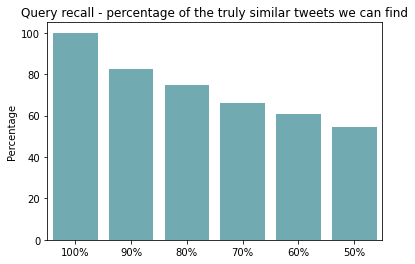

In [16]:
def compare_query_recall(recalls, title): 
    layer = sns.barplot(x=PLOT_X, y=recalls, color="#66B3BA")
    plt.title(title)
    layer.set(ylabel='Percentage')
    plt.show()

recalls = []
true_searches = []
for i in range(len(num_correct_searches)):
    true_searches.append(num_correct_searches[i])
    recall = round((num_correct_searches[i]/num_true_similar) * 100, 2)
    recalls.append(recall)
    chance = PLOT_X[i]
    print('Using {} of terms, we can find {}% truly similar tweets'.format(chance, recall))
    
compare_query_recall(recalls, 'Query recall - percentage of the truly similar tweets we can find')

## Query Precision

In [17]:
# is_predict_similar = query_result_similarity_lookup['Result_75%'] != -1
# predict_similar = query_result_similarity_lookup[is_predict_similar]
# num_predict_similar = predict_similar.shape[0]
# predict_similar
num_predict_similar_lst = []
predict_similar_lst = []
for i in range(len(QUERY_RESULT_COL)):
    is_predict_similar = query_result_similarity_lookup[QUERY_RESULT_COL[i]] != -1
    predict_similar = query_result_similarity_lookup[is_predict_similar]
    predict_similar_lst.append(predict_similar)
    num_predict_similar_lst.append(predict_similar.shape[0])
print("The number of tweets that we think are similar: ")
num_predict_similar_lst

The number of tweets that we think are similar: 


[7247, 7257, 7439, 7532, 7632, 7580]

Using 100% of terms, 100.0% tweets that we found similar are truly similar tweets
Using 90% of terms, 82.33% tweets that we found similar are truly similar tweets
Using 80% of terms, 72.82% tweets that we found similar are truly similar tweets
Using 70% of terms, 63.69% tweets that we found similar are truly similar tweets
Using 60% of terms, 57.85% tweets that we found similar are truly similar tweets
Using 50% of terms, 51.97% tweets that we found similar are truly similar tweets


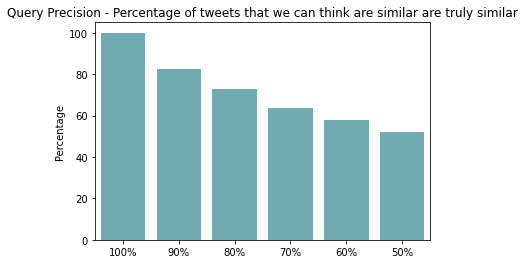

In [18]:
def compare_query_precision(precisions, title): 
    layer = sns.barplot(x=PLOT_X, y=precisions, color="#66B3BA")
    layer.set(ylabel='Percentage')
    plt.title(title)
    plt.show()

precisions = []
for i in range(len(num_predict_similar_lst)):
    precision = round((num_correct_searches[i]/num_predict_similar_lst[i]) * 100, 2)
    precisions.append(precision)
    chance = PLOT_X[i]
    print('Using {} of terms, {}% tweets that we found similar are truly similar tweets'.format(chance, precision))
    
compare_query_precision(precisions, 'Query Precision - Percentage of tweets that we can think are similar are truly similar')

## Number of searches that need fewer lookups

In [19]:
correct_search

Result_100%  Result_90%  Result_80%  Result_70%  Result_60%  \
0           189567      189567      189567      189567      189567   
8            44802       44802       44802       44802       44802   
15          102434      102434      102434      102434      102434   
34          193795      193795      193795      193795      193795   
40             708         708         708         708         708   
...            ...         ...         ...         ...         ...   
21875       197554      197554      197554      197554      197554   
21878       197554      197554      197554      197554      197554   
21880       197554      197554      197554      197554      197554   
21884       178680      178680      178680      178680      178680   
21889       197524      197524      197524      197524      197524   

       Result_50%  Similarity_100%  Similarity_90%  Similarity_80%  \
0          189567          0.63636         0.70000         0.70000   
8           44802          0.60000         0.60000         0.60000   
15         102434          0.50000         0.50000         0.50000   
34         193795          0.60000         0.50000         0.50000   
40            708          1.00000         1.00000         1.00000   
...           ...              ...             ...             ...   
21875      197554          1.00000         1.00000         1.00000   
21878      197554          1.00000         1.00000         1.00000   
21880      197554          1.00000         1.00000         1.00000   
21884      178680          0.62500         0.57143         0.57143   
21889      197524          0.87500         0.87500         0.87500   

       Similarity_70%  Similarity_60%  Similarity_50%  Lookups_100%  \
0               0.700         0.70000         0.55556          5137   
8               0.600         0.60000         0.60000         38975   
15              0.600         0.60000         0.60000         10200   
34              0.500         0.50000         0.50000           365   
40              1.000         1.00000         0.80000         12438   
...               ...             ...             ...           ...   
21875           1.000         0.83333         0.60000             7   
21878           1.000         0.83333         0.60000             7   
21880           1.000         0.83333         0.60000             7   
21884           0.500         0.50000         0.50000           120   
21889           0.875         0.87500         0.87500             8   

       Lookups_90%  Lookups_80%  Lookups_70%  Lookups_60%  Lookups_50%  
0             4080         4060         4110         4110         2538  
8            38485        38600        38790        38790        38835  
15           10032        10092         6910         6900         6920  
34             112          108          112          112          112  
40           12288        12354        12384        12402         9250  
...            ...          ...          ...          ...          ...  
21875            7            7            7            6            5  
21878            7            7            7            6            5  
21880            7            7            7            6            5  
21884           84           84           66           66           66  
21889            8            8            8            8            8  

[3939 rows x 18 columns]

In [20]:
query_of_less_lookups = []
less_search_lst = []
for i in range(len(QUERY_LOOKUPS_COL)):
    if i != 0:
        is_less_search = correct_searches[i][QUERY_LOOKUPS_COL[0]] > correct_searches[i][QUERY_LOOKUPS_COL[i]]
        less_search = correct_searches[i][is_less_search]
        less_search_lst.append(less_search)
        query_of_less_lookups.append(less_search.shape[0])
    else:
        less_search_lst.append(None)
        query_of_less_lookups.append(0)
print("The number of tweets that need less lookups before correctly finding the true similar tweets: ")
query_of_less_lookups

The number of tweets that need less lookups before correctly finding the true similar tweets: 


[0, 5419, 4903, 4359, 4071, 3578]

Using 100% of terms, 0.0% queries need less lookups before correctly finding the true similar tweets
Using 90% of terms, 90.69% queries need less lookups before correctly finding the true similar tweets
Using 80% of terms, 90.51% queries need less lookups before correctly finding the true similar tweets
Using 70% of terms, 90.87% queries need less lookups before correctly finding the true similar tweets
Using 60% of terms, 92.21% queries need less lookups before correctly finding the true similar tweets
Using 50% of terms, 90.84% queries need less lookups before correctly finding the true similar tweets


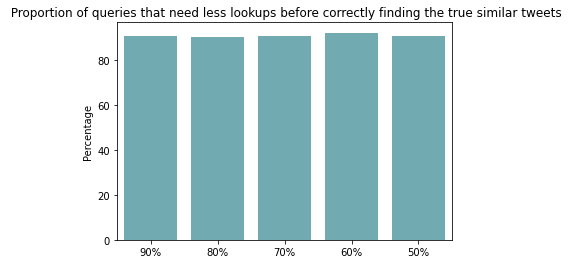

In [21]:
def compare_number_of_tweets_need_less_lookups(reduces, title): 
    layer = sns.barplot(x=PLOT_X[1:], y=reduces, color="#66B3BA")
    layer.set(ylabel='Percentage')
    plt.title(title)
    plt.show()

proportions = []
for i in range(len(query_of_less_lookups)):
    proportion = round((query_of_less_lookups[i] / num_correct_searches[i]) * 100, 2)
    proportions.append(proportion)
    chance = PLOT_X[i]
    print('Using {} of terms, {}% queries need less lookups before correctly finding the true similar tweets'.format(chance, proportion))
    
compare_number_of_tweets_need_less_lookups(proportions[1:], ' Proportion of queries that need less lookups before correctly finding the true similar tweets')

## Number of average lookups

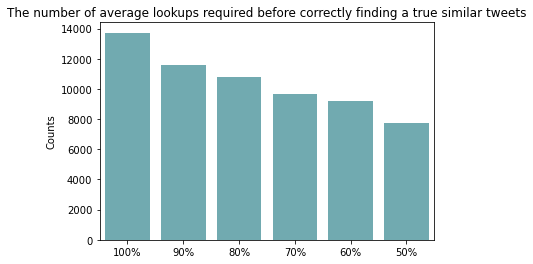

In [22]:
def compare_number_of_avg_lookups(reduces, title): 
    layer = sns.barplot(x=PLOT_X, y=reduces, color="#66B3BA")
    layer.set(ylabel='Counts')
    plt.title(title)
    plt.show()

avg_lookups = []
for i in range(len(QUERY_LOOKUPS_COL)):
    avg_lookup = np.average(np.array(correct_searches[i][QUERY_LOOKUPS_COL[i]]))
    avg_lookups.append(avg_lookup)

compare_number_of_avg_lookups(avg_lookups, 'The number of average lookups required before correctly finding a true similar tweets')

In [23]:
reduces = []
print('Comparing to using all the terms:')
for i in range(len(avg_lookups)):
    if i != 0:
        reduce = round(((avg_lookups[0] - avg_lookups[i]) / avg_lookups[0]) * 100, 2)
        reduces.append(reduce)
        chance = PLOT_X[i]
        print('By using {} of terms, {}% of less lookups are needed for correctly finding a true similar tweets'.format(chance, reduce))

Comparing to using all the terms:
By using 90% of terms, 15.47% of less lookups are needed for correctly finding a true similar tweets
By using 80% of terms, 21.21% of less lookups are needed for correctly finding a true similar tweets
By using 70% of terms, 29.48% of less lookups are needed for correctly finding a true similar tweets
By using 60% of terms, 33.08% of less lookups are needed for correctly finding a true similar tweets
By using 50% of terms, 43.58% of less lookups are needed for correctly finding a true similar tweets


## Index time comparison

In [24]:
index_time = results['index_time']
index_time

Index_time_run1_100%  Index_time_run2_100%  Index_time_run3_100%  \
0                 15.9410               11.5167               13.0898   
1                  8.3719                6.3682                7.4546   
2                  7.7785                6.8198                7.7653   
3                  7.1664                6.5469                5.1706   
4                  7.6008                8.6710                5.0406   
..                    ...                   ...                   ...   
192                3.8869                2.2370                2.2401   
193                3.3585                2.2812                2.2373   
194                3.3035                2.2237                2.2006   
195                3.1376                2.3202                2.0487   
196                3.4274                2.3665                2.1717   

     Index_time_run1_90%  Index_time_run2_90%  Index_time_run3_90%  \
0                18.4211              18.0787              15.6942   
1                 9.1027               7.1659               6.2177   
2                 9.6689               7.2756               6.6710   
3                 7.9577               6.7069               6.7148   
4                 8.3296               6.8283               5.9193   
..                   ...                  ...                  ...   
192               3.8079               3.6990               4.1361   
193               3.5676               3.7826               4.1810   
194               4.3917               3.7103               4.1937   
195               3.6247               3.5269               4.1792   
196               3.7556               3.8625               3.9848   

     Index_time_run1_80%  Index_time_run2_80%  Index_time_run3_80%  \
0                17.9878              19.0274              15.5226   
1                 7.0418               8.3515               7.7486   
2                 6.4585               7.2904               6.3632   
3                 6.4350               7.8667               6.4155   
4                 6.6664               7.7000               5.4562   
..                   ...                  ...                  ...   
192               4.0166               5.1999               3.6308   
193               3.6173               4.4006               3.5386   
194               3.5303               4.2836               3.6122   
195               3.4557               4.3343               3.6055   
196               3.4611               4.0955               4.2789   

     Index_time_run1_70%  Index_time_run2_70%  Index_time_run3_70%  \
0                16.1133              16.3647              16.6331   
1                 8.7804               6.1969               6.4647   
2                 8.1961               5.6480               6.4472   
3                 7.9367               5.9353               6.1933   
4                 6.8421               6.2883               6.1392   
..                   ...                  ...                  ...   
192               3.5231               4.0039               3.8294   
193               3.6546               3.8141               3.6595   
194               3.0113               4.0535               4.1746   
195               3.3357               4.2231               3.5340   
196               3.0590               3.8813               3.7074   

     Index_time_run1_60%  Index_time_run2_60%  Index_time_run3_60%  \
0                16.4439              17.3104              15.9459   
1                 6.7866               7.7688               6.2634   
2                 6.3405               6.8057               6.1646   
3                 5.4170               6.7439               5.9667   
4                 6.3287               5.6430               6.4548   
..                   ...                  ...                  ...   
192               3.9092               4.2286               3.4830   
193               3.8348              18.0822

By using 100% of terms, the average time for indexing 1000 tweets is 4.0722 milliseconds
By using 90% of terms, the average time for indexing 1000 tweets is 4.2679 milliseconds
By using 80% of terms, the average time for indexing 1000 tweets is 4.1915 milliseconds
By using 70% of terms, the average time for indexing 1000 tweets is 4.128 milliseconds
By using 60% of terms, the average time for indexing 1000 tweets is 4.0387 milliseconds
By using 50% of terms, the average time for indexing 1000 tweets is 4.1888 milliseconds


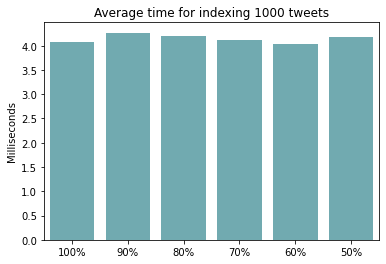

In [25]:
def compare_time(avg_time, title): 
    layer = sns.barplot(x=PLOT_X, y=avg_time, color="#66B3BA")
    layer.set(ylabel='Milliseconds')
    plt.title(title)
    plt.show()

index_time_avgs = []
for col in index_time.columns:
    index_time_avgs.append(np.average(np.array(index_time[col])))

index_time_avgs2 = []
c = 0
acc = 0
for avg in index_time_avgs:
    if c < 2:
        acc += avg
        c += 1
        
    else:
        acc += avg
#         print(acc)
        index_time_avgs2.append(round(acc/3 , 4))
        acc = 0
        c = 0

for i in range(len(index_time_avgs2)):
    print('By using {} of terms, the average time for indexing {} tweets is {} milliseconds'.format(PLOT_X[i], INDEX_TIME_UNIT, index_time_avgs2[i]))
compare_time(index_time_avgs2, 'Average time for indexing {} tweets'.format(INDEX_TIME_UNIT))

## Query time comparison

In [26]:
query_time = results['query_time']
query_time

Query_time_run1_100%  Query_time_run2_100%  Query_time_run3_100%  \
0                 3.6023                3.1659                2.8488   
1               376.5314              299.8045              310.6728   
2               286.7907              199.7412              182.3387   
3               309.6550              201.2273              192.8132   
4               294.3373              204.4198              197.8501   
5               282.5156              196.3902              195.8432   
6               273.7293              191.3612              190.3278   
7               325.3038              207.9694              199.4693   
8               340.1356              201.6763              202.4568   
9               297.7795              183.8891              179.4097   
10              320.4525              200.4499              206.7369   
11              271.1776              175.0140              180.7488   
12              286.4557              192.2469              184.8637   
13              303.7158              178.6509              175.3451   
14              302.5082              177.1728              186.0850   
15              279.3573              182.5796              183.7129   
16              292.1154              187.4614              172.3562   
17              265.6363              175.0300              176.7439   
18              287.1550              212.5614              190.7765   
19              263.1498              192.6695              176.6940   
20              263.5689              169.4549              167.4195   
21              304.5590              194.1021              209.6851   

    Query_time_run1_90%  Query_time_run2_90%  Query_time_run3_90%  \
0                2.0815               4.7279               2.0018   
1              303.0535             302.7024             279.1985   
2              171.5107             179.5362             163.6074   
3              170.1505             185.7496             170.0206   
4              175.1043             221.2747             185.2582   
5              174.5355             226.2834             192.0056   
6              170.3608             179.8112             177.1977   
7              187.4590             203.5462             194.6411   
8              189.2366             184.5992             187.7484   
9              175.2432             168.5993             171.3216   
10             175.3478             176.1743             189.1109   
11             158.6575             164.3576             171.4635   
12             164.7082             165.8161             182.5956   
13             158.5473             157.5035             173.7130   
14             164.4820             172.7389             184.3821   
15             159.1856             156.8529             171.1924   
16             161.8524             162.1324             173.5761   
17             147.2952             147.7221             158.4982   
18             156.4588             160.4275             174.7900   
19             166.2969             173.9084             189.9693   
20             141.2148             146.5910             153.7377   
21             171.1081             173.2201             185.4275   

    Query_time_run1_80%  Query_time_run2_80%  Query_time_run3_80%  \
0                2.9168               2.9883               2.4209   
1              259.1378             238.6825             260.4151   
2              155.2209             182.3946             145.1002   
3              159.6793             170.2270             150.1725   
4              157.6625             181.5562             153.8436   
5              163.7616             164.2675             146.2884   
6              150.6773             206.3197             150.9536   
7              162.8577             163.5386             167.7880   
8              163.0302             163.3310             166.0492   
9              161.6573             155.5005             154.5071   


By using 100% of terms, the average time for querying 1000 tweets is 218.5222 milliseconds
By using 90% of terms, the average time for querying 1000 tweets is 171.0549 milliseconds
By using 80% of terms, the average time for querying 1000 tweets is 149.023 milliseconds
By using 70% of terms, the average time for querying 1000 tweets is 115.8746 milliseconds
By using 60% of terms, the average time for querying 1000 tweets is 100.0634 milliseconds
By using 50% of terms, the average time for querying 1000 tweets is 95.1518 milliseconds


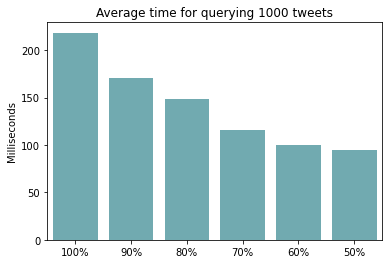

In [27]:
query_time_avgs = []
for col in query_time.columns:
    query_time_avgs.append(np.average(np.array(query_time[col])))

query_time_avgs2 = []
c = 0
acc = 0
for avg in query_time_avgs:
    if c < 2:
        acc += avg
        c += 1
        
    else:
        acc += avg
#         print(acc)
        query_time_avgs2.append(round(acc/3 , 4))
        acc = 0
        c = 0

for i in range(len(query_time_avgs2)):
    print('By using {} of terms, the average time for querying {} tweets is {} milliseconds'.format(PLOT_X[i], INDEX_TIME_UNIT, query_time_avgs2[i]))
compare_time(query_time_avgs2, 'Average time for querying {} tweets'.format(INDEX_TIME_UNIT))